In [3]:
from Functions import *

In [4]:
# import data
data = pd.read_csv(r'C:\Users\Nick\Downloads\Project-3-Chicago-Car-Crashes-main\Project-3-Chicago-Car-Crashes-main\Notebooks\cleaned_data.csv')
data_ = pd.read_csv(r'C:\Users\Nick\Downloads\Project-3-Chicago-Car-Crashes-main\Project-3-Chicago-Car-Crashes-main\Notebooks\cleaned_dummified_data.csv')

## Defining Target & Predictors 

In [5]:
x = data_.drop(['PRIM_CONTRIBUTORY_CAUSE'], axis=1)
y = data_['PRIM_CONTRIBUTORY_CAUSE']
data_['PRIM_CONTRIBUTORY_CAUSE'].value_counts()

0    221682
1     17185
2      7672
3      4257
Name: PRIM_CONTRIBUTORY_CAUSE, dtype: int64

## Splitting Data 

In [7]:
x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.2, random_state=33)

## Building Initial Models

In [8]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RF', RandomForestClassifier(random_state=33)))
models.append(('XGB', XGBClassifier(random_state=33)))

In [9]:
#evaluate each model for accuracy
results = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=33)
    cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    msg = '%s: %0.4f (%0.4f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.8839 (0.0020)
LDA: 0.8682 (0.0025)
KNN: 0.8817 (0.0019)
RF: 0.8401 (0.0012)
XGB: 0.8836 (0.0020)


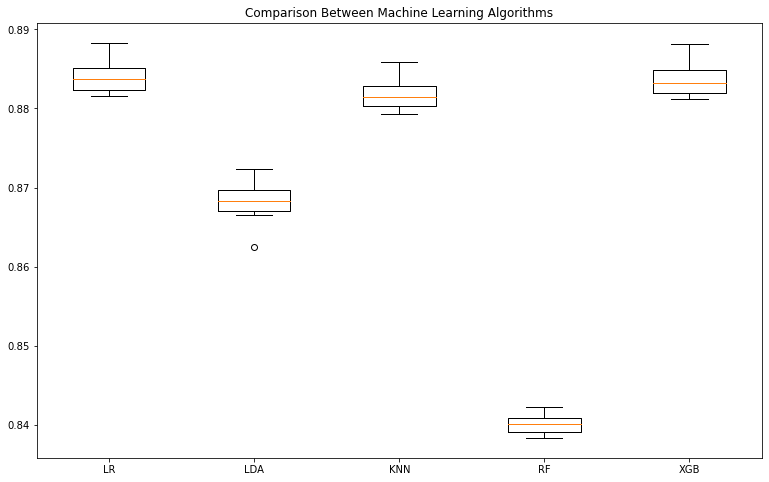

In [10]:
# boxplot algorithm comparison
names = ['LR','LDA','KNN','RF','XGB']
fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(111)
ax.set_title('Comparison Between Machine Learning Algorithms')
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Classification Reports 

In [11]:
# create a classification report for each model
for name, model in models:
    model.fit(x_train, y_train)
    y_pred= model.predict(x_test)
    accuracy= accuracy_score(y_test, y_pred)
    clf_report= classification_report(y_test, y_pred, digits=4)
    print(f"The accuracy of model {type(model).__name__} is {accuracy:.4f}")
    print(clf_report)
    print("\n")

The accuracy of model LogisticRegression is 0.8838
              precision    recall  f1-score   support

           0     0.8838    1.0000    0.9383     44333
           1     0.0000    0.0000    0.0000      3401
           2     0.0000    0.0000    0.0000      1556
           3     0.0000    0.0000    0.0000       870

    accuracy                         0.8838     50160
   macro avg     0.2210    0.2500    0.2346     50160
weighted avg     0.7812    0.8838    0.8293     50160



The accuracy of model LinearDiscriminantAnalysis is 0.8675
              precision    recall  f1-score   support

           0     0.8931    0.9672    0.9287     44333
           1     0.2990    0.1782    0.2233      3401
           2     0.2167    0.0167    0.0310      1556
           3     0.0000    0.0000    0.0000       870

    accuracy                         0.8675     50160
   macro avg     0.3522    0.2905    0.2957     50160
weighted avg     0.8163    0.8675    0.8369     50160



The accuracy of 

KeyboardInterrupt: 

## Using the XGBoost Model 

In [ ]:
XGBmodel = XGBClassifier()
XGBmodel.fit(x_train, y_train)
y_predict = XGBmodel.predict(x_test)

## Initial Confusion Matrix using XGBoost 

In [ ]:
cm = confusion_matrix(y_target=y_test, 
                      y_predicted=y_predict, 
                      binary=False)

labels = ['Driver negligence','External factors','Intoxication','Distraction']
fig, ax = plot_confusion_matrix(conf_mat=cm)
ax.set_xticklabels([''] + labels,rotation=45)
ax.set_yticklabels([''] + labels)

plt.show()

## Using SMOTE to Cure Imbalance 

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 

resampling = SMOTE()

# Define the pipeline, combine SMOTE with the XGB model
pipeline = Pipeline([('SMOTE', resampling), ('XGBoost', XGBmodel)])

In [ ]:
pipeline.fit(x_train, y_train) 
predicted_ = pipeline.predict(x_test)

# Obtain the results from the classification report and confusion matrix 
print('XGBoost classification report:\n', classification_report(y_test, predicted_, digits=4))
conf_mat = confusion_matrix(y_target=y_test, y_predicted=predicted_)

fig, ax = plot_confusion_matrix(conf_mat=conf_mat)
ax.set_title('SMOTE Confusion Matrix')
ax.set_xticklabels([''] + labels,rotation=45)
ax.set_yticklabels([''] + labels)

plt.show()

In [ ]:
parameters_grid = {
    'colsample_bytree': [0.1, 0.5, 0.8, 1],
    'n_estimators': [8, 16, 25, 32],
    'max_depth': [2, 5, 10, 20]}

# Perform grid search
grid_mse = GridSearchCV(estimator=XGBmodel, param_grid=parameters_grid,
                        scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_mse.fit(x, y)

# print the best parameters and lowest RMSE
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))